# 01 - Introduction to seismic modelling

This notebook is the first in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this first example we aim to highlight the core ideas behind seismic modelling, where we create a numerical model that captures the processes involved in a seismic survey. This forward model will then form the basis for further tutorials on the implementation of inversion processes using Devito operators.

## Modelling workflow

The core process we are aiming to model is a seismic survey, which consists of two main components:

- **Source** - A source is positioned at a single physical location where a wave is injected into the domain we want to modelf. In the case of land survey, it is usually dynamite blowing up at a given location, or a vibroseis (a vibrating engine generating continuous  sound waves). For a marine survey, the source is an air gun sending a bubble of compressed air into the water that will expand and generate a seismic wave.
- **Receiver** - A set set of microphones or hydrophones are used to measure the resulting wave and create a set of measurements called a *Shot Record*. These measurements are recoded at multiple locations, and usually at the surface of the domain.

In order to create a numerical model of a seismic survey, we need to solve the wave equation and implement source and receiver interpolation to inject the  source and record the seismic wave at sparse point locations in the grid.


<img src='./survey-ship-diagram.png' width=400>

## The acoustic seismic wave equation
The acoustic wave equation for the square slowness $m$ defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source $q$ is given by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) = q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guarantee unicity of the solution.
The boundary condtions are Dirichlet conditions :

\begin{equation}
 u(x,t)|_\Omega = 0
\end{equation}

where $\Omega$ is the surface of the boundary of the model.


# Finite domains

The last piece of the puzzle is the computational limitation. In the field, the seismic wave propagates in every directions to an "infinite" distance. However, solving the wave equation in a mathematically infinite domain is not feasible. In order to compensate, Absorbing Boundary Conditions (ABC) or Perfctly Matched Layers (PML) are required to mimic an infinite domain. These two method allow to approximate an infinte media by damping and absorbing the waves at the limit of the domain to avoid reflections.

The simplest of these methods is the absorbing damping mask. The core idea is to extend the physical domain and to add a Sponge mask in this extension that will absorb the incident waves. The acoustic wave equation with this damping mask can be rewritten as:

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) + \eta \frac{d u(x,t)}{dt}=q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

where $\eta$ is the damping mask equal to $0$ inside the physical domain and increasing inside the sponge layer. Multiple choice of profile can be chosen for $\eta$ from linear to exponential.

# Seismic modelling with devito

We desribe here a step by step stup of seismic modelling with devito in a simple 2D case.


## Define the physical problem

The first step is to define the physical model:

- What are the physical dimension of interest
- What is the velocity profile of this pysical domain

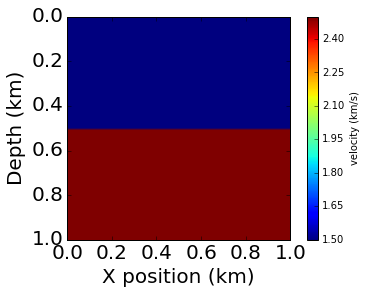

In [1]:
import numpy as np
from examples.seismic import plot_velocity
%matplotlib inline

# We import now the Model abstraction for seismic modeling
from examples.seismic import Model

# Define a physical size
n = (101, 101)  # Number of grid point (nx, nz)
d = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary tto define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s

v = np.ones(n, dtype=np.float32) +.5
v[:, 51:] = 2.5

plot_velocity(v, origin, d, n)

# With the velocity and model size defined, we can create the seismic model that
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points

model = Model(origin, d, n, v, nbpml=10)

# Acquisition geometry

Let's define a source with it's location and a receiver array.
The source time signature we use is a Ricker wavelet defined as

\begin{equation}
  q(t) = (1-2\pi^2 f_0^2 (t - \frac{1}{f_0})^2 )e^{- \pi^2 f_0^2 (t - \frac{1}{f_0})}
\end{equation}

The source is positioned at a 20m depth and at the middle of the $x$ axis ($x_{src}=500m$) while the receivers are positioned at the same depth every $10m$ along the x axis.

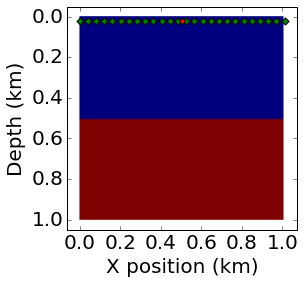

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Import require devito class

from examples.seismic import PointSource, Receiver

# First we need to define the time duration of the simulation and the frequency of the source

t0 = 0.  # Simulation starts a t=0
tn = 1000. # Simulation last 1 second (1000 ms)
f0 = 0.010  # SOurce peak frequency is 10Hz (0.010 kHz)

dt = model.critical_dt  # Computational time step. This value is obtained from
# the maximum velocity and the grid size and is defined with the CFL condition. This is the 
# numerical condition to ensure the discrete model is stable. We will define it properly
# later on but is required here.
nt = int(1+(tn-t0)/dt)  # Discrete time axis length
# Source initalization


def Ricker(t, f0):
    r = (np.pi * f0 * (t - 1./f0))
    return (1-2.*r**2)*np.exp(-r**2)

time_series = np.zeros((nt, 1))
time_series[:, 0] = Ricker(np.linspace(t0, tn, nt), f0)

# We only have a single source
location = np.zeros((1, 2))
location[0, 0] = origin[0] + n[0] * d[0] * 0.5
location[0, 1] = 20.

src = PointSource(name='src', data=time_series, coordinates=location)


# Receiver initialization. This one does not contain any data as it will be computed during
# the simulation.

receiver_coords = np.zeros((101, 2))
receiver_coords[:, 0] = np.linspace(0, origin[0] +
                                    n[0] * d[0], num=101)
receiver_coords[:, 1] = location[0, 1]
rec = Receiver(name='rec', ntime=nt, coordinates=receiver_coords)

# Visualization. We show the acquisition geometry on the next figure where the red dot is the
# source position and the green dots are the receivers locations

plt.figure()
plt.imshow(np.transpose(v), vmin=min(v.reshape(-1)), vmax=max(v.reshape(-1)), cmap=cm.jet, 
           extent=[origin[0], origin[0] + 1e-3 * (n[0]-1) * d[0],
           origin[1] + 1e-3*(n[1]-1) * d[1], origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
plt.scatter(1e-3*receiver_coords[::4, 0], 1e-3*receiver_coords[::4, 1], s=25, c='green', marker='D')
plt.scatter(1e-3*location[0, 0], 1e-3*location[0, 1], s=25, c='red', marker='o')
plt.show()

## Seting up the PDE

# Finite-difference discretization

Devito is a finite-difference DSL that solves the discretized wave-equation on a cartesian grid. The finite-difference approximation is derived from Taylor expansions of the continuous field after removing the error term.

## Time discretization

We only consider the second order time discretization for now. From the Taylor expansion, the second order discrete approximation of the second order time derivative is:
\begin{equation}
\begin{aligned}
 \frac{d^2 u(x,t)}{dt^2} = \frac{\mathbf{u}(\mathbf{x},\mathbf{t+\Delta t}) - 2 \mathbf{u}(\mathbf{x},\mathbf{t}) + \mathbf{u}(\mathbf{x},\mathbf{t-\Delta t})}{\mathbf{\Delta t}^2} + O(\mathbf{\Delta t}^2).
\end{aligned}
\end{equation} 

where $\mathbf{u}$ is the discrete wavefield, $\mathbf{\Delta t}$ is the discrete
time-step (distance between two consecutive discrete times) and $O(\mathbf{\Delta
  t}^2)$ is the discretization error term. The discretized approximation of the
second order time derivative is then given by dropping the error term. This derivative is represented in Devito by `u.dt2` where u is a `TimeData` object.

## Spatial discretization 

We define the discrete Laplacian as the sum of the second order spatial
derivatives in the three dimensions:
\begin{equation}
\begin{aligned}
\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t})= \sum_{j=1}^{j=\frac{k}{2}} \Bigg[\alpha_j \Bigg(&
\mathbf{u}(\mathbf{x+jdx},\mathbf{y},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x-jdx},\mathbf{y},\mathbf{z},\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y+jdy},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y-jdy},\mathbf{z}\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z+jdz},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z-jdz},\mathbf{t})\Bigg) \Bigg] + \\
&3\alpha_0 \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}).
\end{aligned}
\end{equation}

This derivative is represented in Devito by `u.laplace` where u is a `TimeData` object.

## Wave equation

With the space and time discretization defined, we can fully discretize the
wave-equation with the combination of time and space discretizations and obtain the following second order in time and
$k^{th}$ order in space discrete stencil to update one grid point
at position $\mathbf{x}, \mathbf{y},\mathbf{z}$ at time $\mathbf{t}$, i.e.
\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}



In [3]:
# Let's import a few required component

# In order to represent the wavefield u, and the squre slownees we need symbolic object 
# corresponding to time-space-varying field (u, TimeData) and 
# space-varying field (m, DenseData)
from devito.interfaces import TimeData

# Deine the wavefield with the size of the model and the time dimension

u = TimeData(name="u", shape=model.shape_domain, time_dim=nt, time_order=2, space_order=2, save=True)

# We can now write the pde

pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then reqrite the pde as 
# a time marching updating equation known as a stencil using sympy functions

from sympy import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward)[0])

# Finally we define the source injection and receiver read function to generate the corresponding code

src_term = src.inject(field=u, offset=model.nbpml, expr=src * dt * dt / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u, offset=model.nbpml)

# Devito operator and solve

In [4]:
# With all the necessary obkjects created we can create the Devito operator that will generate the
# C code at runtime
from sympy.abc import s, h
from devito.operator import Operator
op = Operator([stencil] + src_term + rec_term, subs={s: dt, h: d[0]})

# The creation of the operators prints the optimizations made on the stencil to
# optimize the computation

DSE: extract_time_invariants [flops: 22, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 22, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 22, elapsed: 0.00] >>
     factorize [flops: 19, elapsed: 0.02] >>
     finalize [flops: 19, elapsed: 0.00]
     [Total elapsed: 0.03 s]
DLE: analyze [elapsed: 0.01] >>
     avoid_denormals [elapsed: 0.00] >>
     loop_fission [elapsed: 0.01] >>
     create_elemental_functions [elapsed: 0.01] >>
     loop_blocking [elapsed: 0.12] >>
     simdize [elapsed: 1.11]
     [Total elapsed: 1.25 s]


In [5]:
op.apply()

CustomCompiler: compiled /tmp/devito-1000/ca7373d1de2d1132ca25d36db1d799ff12c34dcb.c [0.51 s]
Section loop_p_src_1<595,1> with OI=0.73 computed in 0.000 s [Perf: 0.26 GFlops/s]
Section loop_p_rec_2<595,101> with OI=1.37 computed in 0.002 s [Perf: 1.30 GFlops/s]
Section main<595,120,120> with OI=1.17 computed in 0.033 s [Perf: 4.90 GFlops/s]


PerformanceSummary([('loop_p_src_1',
                     PerfEntry(time=9.399999999999983e-05, gflopss=0.25952127659574514, oi=0.7309144295302014, itershape=[595, 1], datashape=[596, 1])),
                    ('loop_p_rec_2',
                     PerfEntry(time=0.0015260000000000078, gflopss=1.2995642201834796, oi=1.3726929530201342, itershape=[595, 101], datashape=[596, 101])),
                    ('main',
                     PerfEntry(time=0.03319099999999995, gflopss=4.904703082160834, oi=1.165993355975153, itershape=[595, 120, 120], datashape=[596, 121, 121]))])

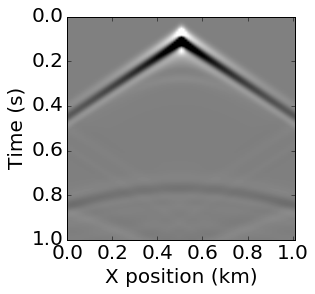

In [6]:
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, origin, d, n, t0, tn)